<img src="cetelem1b.jpg" />

# Imports

In [1]:
# Math et données
import numpy as np
# import scipy
# from scipy.stats import zscore
import pandas as pd
from datetime import date
import itertools

# Librairies graphiques
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Public\wpython\V_3.7.6\soft\python-3.7.6.amd64\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [72]:
# Pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Feature selection
from sklearn.model_selection import GridSearchCV, KFold

# ML
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
import joblib

In [4]:
# Modules perso
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [5]:
import DisplotData, PwePwocess, Funktiuns
from DisplotData import bcolors
import MLstuff

In [6]:
pd.set_option("display.max_columns", 150) # None

# Chargement des données

In [7]:
data_dir = "../input/"

In [8]:
df_application_train = pd.read_csv(data_dir+'application_train.csv')
df_application_test = pd.read_csv(data_dir+'application_test.csv')


In [9]:
df_bureau = pd.read_csv(data_dir+'bureau.csv')
df_bureau_balance = pd.read_csv(data_dir+'bureau_balance.csv')
df_credit_card_balance = pd.read_csv(data_dir+'credit_card_balance.csv')
df_installments_payments = pd.read_csv(data_dir+'installments_payments.csv')
df_POS_CASH_balance = pd.read_csv(data_dir+'POS_CASH_balance.csv')
df_previous_application = pd.read_csv(data_dir+'previous_application.csv')

# Exploration des données

## Variables initiales

<img src="home_credit.png" />

### Description des colonnes

```
- **application_{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

 - **bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

 - **bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

 - **POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

 - **credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

 - **previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

 - **installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

 - **HomeCredit_columns_description.csv**

This file contains descriptions for the columns in the various data files.
```

 - **application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

 - **bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

 - **bureau_balance.csv**

Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

 - **POS_CASH_balance.csv**

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

 - **credit_card_balance.csv**

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

 - **previous_application.csv**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

 - **installments_payments.csv**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

 - **HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [10]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
df_application_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.1034,0.0833,0.1250,0.0579,0.0202,0.0257,0.0000,0.0000,0.0252,0.0451,0.9727,0.6406,0.0022,0.0000,0.1034,0.0833,0.1250,0.0592,0.0220,0.0267,0.0,0.0000,0.0250,0.0435,0.9727,0.6310,0.0022,0.00,0.1034,0.0833,0.1250,0.0589,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.2

In [12]:
df_application_train.shape

(307511, 122)

In [13]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [14]:
df_application_test.tail()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.002042,-19970,-5169,-9094.0,-3399,NaN,1,1,1,1,1,0,NaN,1.0,3,3,WEDNESDAY,16,0,0,0,0,0,0,Other,NaN,0.648575,0.643026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-684.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-11186,-1149,-3015.0,-3003,NaN,1,1,0,1,0,0,Sales staff,4.0,2,2,MONDAY,11,0,0,0,0,1,1,Trade: type 7,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037,-2681.0,-1504,4.0,1,1,0,1,1,0,NaN,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1383,NaN,0.0542,0.1134,0.1415,0.9955,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1441,NaN,0.0574,0.1124,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1408,NaN,0.0554,NaN,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,2

In [15]:
df_application_test.shape

(48744, 121)

In [16]:
456222 in df_bureau['SK_ID_CURR'].values

False

In [17]:
456253 in df_bureau['SK_ID_CURR'].values

True

In [18]:
for ids in [100005, 456222]:
    print(f"ids: {ids}")
    for df in [df_bureau,
            df_bureau_balance,
            df_credit_card_balance,
            df_installments_payments,
            df_POS_CASH_balance,
            df_previous_application]:
        if 'SK_ID_CURR' in df.columns: 
            print(ids in df['SK_ID_CURR'].values)

ids: 100005
True
False
True
True
True
ids: 456222
False
False
True
True
True


Donc certains ID sur lesquels la compétition demande une prédiction **n'ont pas d'informations complémentaires dans toutes les autres tables que celles données dans `application_test.csv` !**
 - [ ] Confirmer avec Yann que celà implique que l'algorithme choisi doit être robuste aux NaN pour les variables supplémentaires (par rapport à celle dans `application_{train|test}.csv`), ou bien que la démarche de FE les impute

OK donc la target est sur les **difficultés de paiement*(1: oui, 0: non), càd plus de X jours de retard sur les Y premières échéances.
Infos : 
 - client possède une voiture
 - client possède un appartement ou une maison
 - prix des biens pour un prêt à la consommation
 - Qui accompagnait le client lors de sa demande de prêt ?!
 - NAME_HOUSING_TYPE : type de logement actuel du client (locataire, vivant avec les parents...)
 - DAYS_REGISTRATION : Combien de jours avant la demande le client a-t-il modifié son inscription ?!
 - DAYS_ID_PUBLISH : Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt
 - Age de la voiture du client !!
 - FLAG_CONT_MOBILE : le portable a pû être joint !!
 - Score de région du client (par l'organisme de prêt) !
 - Quel jour de la semaine le client a-t-il demandé le prêt !!
 - A quelle heure dans le jour le client a-t-il demandé le prêt !!
 - Score en provenance d'autres sources (3 possibles), normalisé
 - Lieu de vie du client : taille de l'appartement, aire commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages
 - Combien d'observations de l'environnement social du client avec un défaut observable de 30 DPD (jours de retard) ?!
 - Combien d'observations de l'environnement social du client ont manqué 30 DPD (jours de retard) ?
 - Nombre de jours entre le changement de téléphone portable du client et la demande de prêt ?!
 - Nombre de demandes de renseignements au bureau de crédit au sujet du client une heure/mois/trimestre/année avant la demande (moins une période de marge)
 - CC : Montant tiré au cours du mois du crédit précédent
 - CC : Montant des autres tirages au cours du mois du crédit précédent
 - CC : Nombre de tirages au guichet automatique durant ce mois sur le crédit précédent
 - PA : AMT_DOWN_PAYMENT : Acompte sur la demande précédente (Down payment on the previous application)
 - PA : Par rapport à la demande actuelle, quand la décision concernant la demande précédente a-t-elle été prise
 - PA : Le client était-il un ancien ou un nouveau client lors de la demande précédente ?
 - PA : Par rapport à la date d'application de l'application actuelle, à quand remonte le premier décaissement de l'application précédente
 - IP : Version du calendrier des versements (0 pour carte de crédit) du crédit précédent. Le changement de version de versement d'un mois à l'autre signifie que certains paramètres du calendrier de paiement ont changé
 - IP : Sur quel versement nous observons le paiement ?!
 - IP : **DAYS_ENTRY_PAYMENT : Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt en cours)**

DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE

In [20]:
df_application_train.shape

(307511, 122)

In [21]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [22]:
df_bureau.shape

(1716428, 17)

In [23]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [24]:
df_bureau_balance.shape

(27299925, 3)

In [91]:
df_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [25]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [26]:
df_credit_card_balance.shape

(3840312, 23)

In [27]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [28]:
df_installments_payments.shape

(13605401, 8)

In [29]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_previous_application.shape

(1670214, 37)

In [89]:
df_application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [90]:
for df, df_name in [
           [df_application_train, 'df_application_train'],
           [df_application_test, 'df_application_test'],
           [df_bureau, 'df_bureau'],
           [df_bureau_balance, 'df_bureau_balance'],
           [df_credit_card_balance, 'df_credit_card_balance'],
           [df_installments_payments, 'df_installments_payments'],
           [df_POS_CASH_balance, 'df_POS_CASH_balance'],
           [df_previous_application, 'df_previous_application'],
           ]:
#     print(f"\ndf_name:\n{df.columns}")
       print('STATUS' in df.columns)

False
False
False
True
False
False
False
False


### Taux de valeurs manquantes

### Value counts

In [32]:
for df in [df_bureau,
           df_bureau_balance,
           df_credit_card_balance,
           df_installments_payments,
           df_POS_CASH_balance,
           df_previous_application]:
    DisplotData.print_value_counts(df, exclude=['OSEBuildingID'])

Légende :


Colonne numérique
-----------------


Colonne catégorielle
--------------------


----------------------------------------------------------------------------------------------------


CREDIT_TYPE
-----------
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                               

### Sélection des premières variables de travail

### Fusion des doublons

### Suppression des lignes contenant des valeurs manquantes

### Nettoyage

### Imputations

# Noyau Kaggle 1 

In [33]:
import re

In [103]:
dd = pd.DataFrame({'A':['aaa', 'bbb', 'aaa', 'bbb', 'ccc'], 'B':[1,0,3,1,2], 'C':['ttt','fff','hhh','rrrr','sss']})
dd.groupby('A').agg('size')

A
aaa    2
bbb    2
ccc    1
dtype: int64

In [139]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    # df = df_application_train
    test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    # test_df = df_application_train
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df, cat_cols

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    # bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb = df_bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    bb_cat2 = []
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    print('AVANT', bb_agg.columns.tolist()) # DEBUG
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    print('APRES', bb_agg.columns)
    # *** ICI on a modifié le nom des colonnes, donc cat_cols doit devenir cette nouvelle liste
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg, bb_cat, bureau_cat

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    # prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev = df_previous_application
    prev, prev_cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev.loc[prev['APP_CREDIT_PERC']>1.e300] = 1. # CG
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in prev_cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg, prev_cat_cols

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    # pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos = df_POS_CASH_balance
    pos, pos_cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in pos_cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg, pos_cat_cols
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    # ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins = df_installments_payments
    ins, ins_cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins.loc[ins['PAYMENT_PERC']>1.e300] = 1. # CG
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in ins_cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg, ins_cat_cols

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    # cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc = df_credit_card_balance
    cc, cc_cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg, cc_cat_cols

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, n_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': 0.02,
            'num_leaves': 34,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775,
            'verbose': -1,
            'silent': -1,
        }
        callbacks = [early_stopping(stopping_rounds=200, verbose=0)] #, lgb.log_evaluation(period=0)
        # clf = LGBMClassifier(params)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
            # eval_metric= 'auc', verbose= 200, callbacks=callbacks)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df, train_df, test_df

# RandomForest with KFold or Stratified KFold
def kfold_randomforest(df, cat_cols, num_cols, n_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting RandomForest. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=n_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    cat_cols = [f for f in cat_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    num_cols = [f for f in num_cols if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # TODO: SALE
    
    # Parameters
    params = {'n_estimators': [200], #[20, 50, 100, 200]
              'max_depth': [None], #[None, 1, 2, 5],
              'min_samples_split': [2], #[2, 5, 10], 
             }

    # Split train/test
    X = train_df[feats]
    y = train_df['TARGET']

    for col in X.columns: # DEBUG
        if X_enc.loc[X_enc[col].isna(), col].shape[0]:
            print(col)
            
    # categorical_columns = [] #[col for col in df.columns if df[col].dtype == 'object']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), ("scaler", StandardScaler())] # strategy="median"
    )

    # categorical_transformer = OneHotEncoder(handle_unknown="ignore") # Déjà OneHotEncodé, et les NaN remplacés à 1 pour la catég _nan

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, feats), #num_cols
            # ("cat", categorical_transformer, cat_cols),
        ]
    )
    preprocessor.fit(X)
    X_enc = preprocessor.transform(X)

    train_x, test_x, train_y, test_y = train_test_split(X_enc, y, test_size=0.2, random_state=18011975, stratify=y)
    clf = GridSearchCV(
        RandomForestClassifier(),
        param_grid=params,
        cv=n_folds,
        scoring='roc_auc')
    clf.fit(train_x, train_y)


    oof_preds = clf.predict_proba(test_x, num_iteration=clf.best_iteration_)[:, 1]
    # sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    # fold_importance_df = pd.DataFrame()
    # fold_importance_df["feature"] = feats
    # fold_importance_df["importance"] = clf.feature_importances_
    # fold_importance_df["fold"] = n_fold + 1
    # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = clf.feature_importances_
    
    print('AUC : %.6f' % (roc_auc_score(test_y, oof_preds)))
    
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        # test_df['TARGET'] = sub_preds
        # test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        pass
    display_importances(feature_importance_df)
    return feature_importance_df, train_df, test_df


def preprocess(debug = False):
    num_rows = 10000 if debug else None
    df, cat_cols = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau, bb_cat, bureau_cat = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        cat_cols += bb_cat + bureau_cat
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev, prev_cat_cols = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        cat_cols += prev_cat_cols
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos, pos_cat_cols = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        cat_cols += pos_cat_cols
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins, ins_cat_cols = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        cat_cols += ins_cat_cols
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc, cc_cat_cols = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        cat_cols += cc_cat_cols
        del cc
        gc.collect()

    # CG : correction nom de features qui crashe LGBM
    # df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    cat_cols = [c for c in cat_cols if c not in ['TARGET']]
    num_cols = list(set(df.columns) - set(cat_cols) - set(['TARGET']))

    return df, cat_cols, num_cols

def main(debug = False):
    df, cat_cols, num_cols = preprocess(debug)

    with timer("Run LightGBM with kfold"):
        # feat_importance, train_df, test_df = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
        feat_importance, train_df, test_df = kfold_randomforest(df, n_folds=10, stratified=True, debug=debug)
    return feat_importance, train_df, test_df


In [129]:
debug = False
df, cat_cols, num_cols = preprocess(debug=debug)

Train samples: 307511, test samples: 48744
AVANT [('MONTHS_BALANCE', 'min'), ('MONTHS_BALANCE', 'max'), ('MONTHS_BALANCE', 'size'), ('STATUS_0', 'mean'), ('STATUS_1', 'mean'), ('STATUS_2', 'mean'), ('STATUS_3', 'mean'), ('STATUS_4', 'mean'), ('STATUS_5', 'mean'), ('STATUS_C', 'mean'), ('STATUS_X', 'mean'), ('STATUS_nan', 'mean')]
APRES Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
       'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN',
       'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN',
       'STATUS_nan_MEAN'],
      dtype='object')
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338858, 249)
Process previous_applications - done in 16s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339585, 26)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process c

In [140]:
with timer("Run RandomForest with kfold"):
    # feat_importance, train_df, test_df = kfold_lightgbm(df, n_folds=10, stratified=True, debug=debug)
    feat_importance, train_df, test_df = kfold_randomforest(df, cat_cols, num_cols, n_folds=10, stratified=True, debug=debug)


Starting RandomForest. Train shape: (307507, 798), test shape: (48744, 798)
AMT_ANNUITY
AMT_GOODS_PRICE
DAYS_EMPLOYED
OWN_CAR_AGE
CNT_FAM_MEMBERS
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_C

In [138]:
for col in train_df.columns:
    if train_df.loc[train_df[col].isna(), col].shape[0]:
        print(col)

NameError: name 'train_df' is not defined

In [125]:
1.e300<np.inf

True

In [116]:
df.loc[df['PREV_APP_CREDIT_PERC_MAX']>1.e20, 'PREV_APP_CREDIT_PERC_MAX']

201086    inf
Name: PREV_APP_CREDIT_PERC_MAX, dtype: float64

In [117]:
df.loc[df['REFUSED_APP_CREDIT_PERC_MAX']>1.e20, 'REFUSED_APP_CREDIT_PERC_MAX']


201086    inf
Name: REFUSED_APP_CREDIT_PERC_MAX, dtype: float64

In [118]:
df.loc[df['INSTAL_PAYMENT_PERC_MAX']>1.e20, 'INSTAL_PAYMENT_PERC_MAX']


5687      inf
60477     inf
79077     inf
89018     inf
98509     inf
126768    inf
128791    inf
140426    inf
152087    inf
167136    inf
199103    inf
236164    inf
238381    inf
272829    inf
277962    inf
287300    inf
292852    inf
305373    inf
310339    inf
Name: INSTAL_PAYMENT_PERC_MAX, dtype: float64

In [ ]:
df['FLAG_OWN_REALTY'].dtype

dtype('int64')

In [36]:
feature_importance_df_essai = pd.DataFrame(data={'feature':['CNT_CHILDREN','CODE_GENDER','AMT_INCOME_TOTAL', 'CNT_CHILDREN','CODE_GENDER','AMT_INCOME_TOTAL'],
                                                #  'importance':[50,40,60,50],,[40,50,40,50], :[20,30,20,30]}, ,])
                                                 'importance':[40,50,30, 30,40,20],
                                                 'fold':[1,1,1,2,2,2]})
feature_importance_df_essai

,feature,importance,fold
0,CNT_CHILDREN,40,1
1,CODE_GENDER,50,1
2,AMT_INCOME_TOTAL,30,1
3,CNT_CHILDREN,30,2
4,CODE_GENDER,40,2
5,AMT_INCOME_TOTAL,20,2


In [37]:
# Display/plot feature importance
def display_importances(feature_importance_df_, n_feat=40):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:n_feat].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    result = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    plt.figure()
    # sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    sns.barplot(x="importance", y="feature", data=best_features, order=result)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

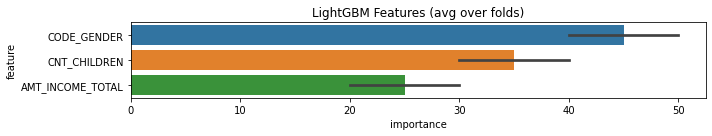

In [38]:
plt.rcParams['figure.figsize'] = [10, 2]
display_importances(feature_importance_df_essai, 3)

DCQJC, on a tout à fait le droit d'ajouter les informations provenant des autres tables, et celles que l'on a créées, aux Dataframes train et test.

In [42]:
feature_importance_df_lgbm = feature_importance_df

NameError: name 'feature_importance_df' is not defined

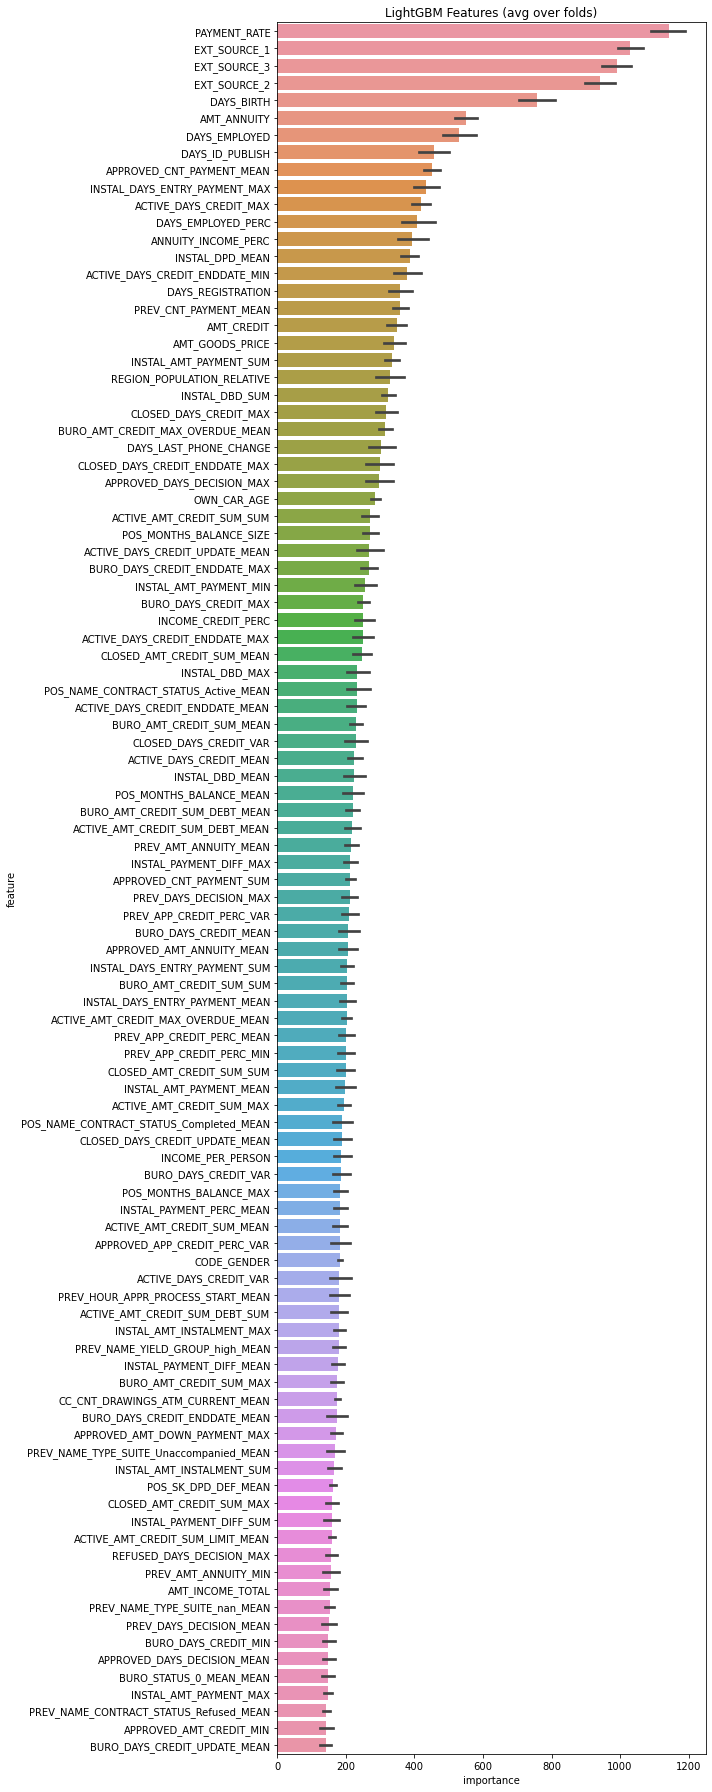

In [ ]:
plt.rcParams['figure.figsize'] = [10, 25]
display_importances(feature_importance_df, 100)

In [ ]:
train_df.isna().sum()

index                                    0
SK_ID_CURR                               0
TARGET                                   0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     220602
CC_NAME_CONTRACT_STATUS_nan_MEAN    220602
CC_NAME_CONTRACT_STATUS_nan_SUM     220602
CC_NAME_CONTRACT_STATUS_nan_VAR     221234
CC_COUNT                            220602
Length: 798, dtype: int64

# TODO

 **Mentorat 26/10**
 - [ ] VisualStudio : good (mieux en noir ^^)
 - [ ] Données : éviter de passer trop de temps à sélectionner et travailler ses données + d'autres contrib qui ont bien perfé
 - [ ] Modélisation : 60% (dont SHAP)
 - [ ] Dashboard : 30%
 - [ ] API : 10% (Flask conseillé, d'autant que c'est du Python, les trucs tout faits c'est cac... dommage)

**Perso**
- [X] Comprendre si et comment le noyau suggéré se sert des infos des autres tables.
- [X] Vérifier qu'un ID dans la table test a bien des infos dans ces autres tables : NON !
- [X] Du coup regarder le taux de NaN dans les df_train et df_test, du noyau Kaggle : pas mal, et ça ne gêne pas LightGBM
- [X] Comprendre le diagramme de feature importance :
    - [X] pourquoi seulement 40
    - [X] que représente réellement le trait : IC ? min;max ? oui, il fait croire, sur un test
    - [X] pourquoi le classement affiché n'est pas réellement décroissant, même quand on tient compte des bornes de l'intervalle du trait ? Je ne sais pas, mais c'est résolu en spécifiant un paramètre order à sns.barplot()
- [ ] Extraire les 100 features les plus importantes de LighGBM
- [ ] Déterminer correctement l'ensemble des colonnes cétagorielles et numériques après les différentes transformations
- [ ] Passer un SimpleImputer aux colonnes numériques (les NaN dans les cols catég. sont normalement devenus des 1 dans une noubelle catég. _nan)
- [ ] Passer un KNNImputer aux colonnes numériques
- [ ] Pipeliner les imputations et scaling à RandomForest
- [ ] Faire aboutir RandomForest
- [ ] Extraire les 100 features les plus importantes de RandomForest
- [ ] Les comparer à celles de LightGBM
- [ ] Ajouter des features perso (nb de soldes négatifs dans les 6 derniers mois, etc., voir portable)
- [ ] Corrections de :
    - [ ] `ORGANIZATION_TYPE_Industry: type 1`
    - [ ] `NAME_FAMILY_STATUS_Single / not married`

In [60]:
np.median([0, 1], )

0.5